In [2]:
from sqlite3 import connect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, chi2_contingency
import scikit_posthocs as sp

In [3]:
conn = connect("../../data/ices.db")

In [4]:
query = """
SELECT 
    IIF(retrieval_method = 'bm25', 'Sparse', IIF(retrieval_method = 'chroma', 'Dense', 'Composite')) AS [Retrieval Method],
    query_type AS [Query Type],
    retrieved_position AS [Retrieved Position]
FROM 
    evaluations
LEFT JOIN
    evaluation_queries ON evaluations.evaluation_query_id = evaluation_queries.id

UNION ALL

SELECT 
    IIF(retrieval_method = 'bm25', 'Sparse', IIF(retrieval_method = 'chroma', 'Dense', 'Composite')) AS retrieval_method,
    'All',
    retrieved_position
FROM 
    evaluations
LEFT JOIN
    evaluation_queries ON evaluations.evaluation_query_id = evaluation_queries.id
"""
data = pd.read_sql(query, conn)
data['Query Type'] = data['Query Type'].apply(lambda x: x.title())
data.head()

,Retrieval Method,Query Type,Retrieved Position
0,Dense,Short,6
1,Sparse,Short,71
2,Composite,Short,3
3,Dense,Short,2
4,Sparse,Short,490


In [5]:
#
# TODO: LOOK INTO HOW COMPOSITE CAN RANK GREATER THAN TOTAL NUMBER OF ABSTRACTS (2781)
data['Retrieved Position'] = data['Retrieved Position'].apply(lambda x: x if x <= 2781 else 2781)

In [6]:
summary = data.groupby(['Retrieval Method', 'Query Type']).agg({
        'Retrieved Position': [
            'count',
            'mean', 
            'std',
            lambda x: x.mode().iloc[0] if not x.mode().empty else None, # mode
            'min',
            lambda x: int(x.quantile(0.25)),  # Q1
            lambda x: int(x.quantile(0.5)),   # Q2
            lambda x: int(x.quantile(0.75)),  # Q3
            'max',
            lambda x: int(x.max() - x.min()), # range
            lambda x: int(x.quantile(0.75) - x.quantile(0.25)), # IQR
            'skew',
            lambda x: ((x - x.mean())**4).mean() / (x.std()**4) - 3  # kurtosis
        ]
    }).round(2).rename(columns={
            'count': 'Count',
            'mean': 'Mean',
            'std': 'Std',
            '<lambda_0>': 'Mode',
            'min': 'Min',
            '<lambda_1>': 'Q1',
            '<lambda_2>': 'Median',
            '<lambda_3>': 'Q3',
            'max': 'Max',
            '<lambda_4>': 'Range',
            '<lambda_5>': 'IQR',
            'skew': 'Skew',
            '<lambda_6>': 'Kurtosis'
        }
    ).reset_index()
summary

Retrieval Method Query Type Retrieved Position                           \
                                           Count    Mean     Std Mode Min   
0        Composite        All               3001   33.83  113.41    1   1   
1        Composite       Long               1500   14.26   16.85    1   1   
2        Composite      Short               1501   53.39  157.08    1   1   
3            Dense        All               3001    9.75   55.69    1   1   
4            Dense       Long               1500    1.98    4.43    1   1   
5            Dense      Short               1501   17.51   77.86    1   1   
6           Sparse        All               3001  731.05  746.51    1   1   
7           Sparse       Long               1500  792.43  778.06    7   1   
8           Sparse      Short               1501  669.71  708.55    1   1   

                                                       
    Q1 Median    Q3   Max Range   IQR   Skew Kurtosis  
0    5     13    25  2781  2780    20  12.15   214.24  
1    3     11    19   261   260    16   5.78    59.16  
2    5     15    35  2781  2780    30   8.78   110.55  
3    1      1     3  2058  2057     2  21.14   660.43  
4    1      1     1    78    77     0   9.23   108.62  
5    1      2     7  2058  2057     6  15.18   338.02  
6  104    445  1204  2758  2757  1100   0.99    -0.17  
7  121    511  1318  2749  2748  1196   0.86    -0.49  
8   89    388  1075  2758  2757   986   1.11     0.21

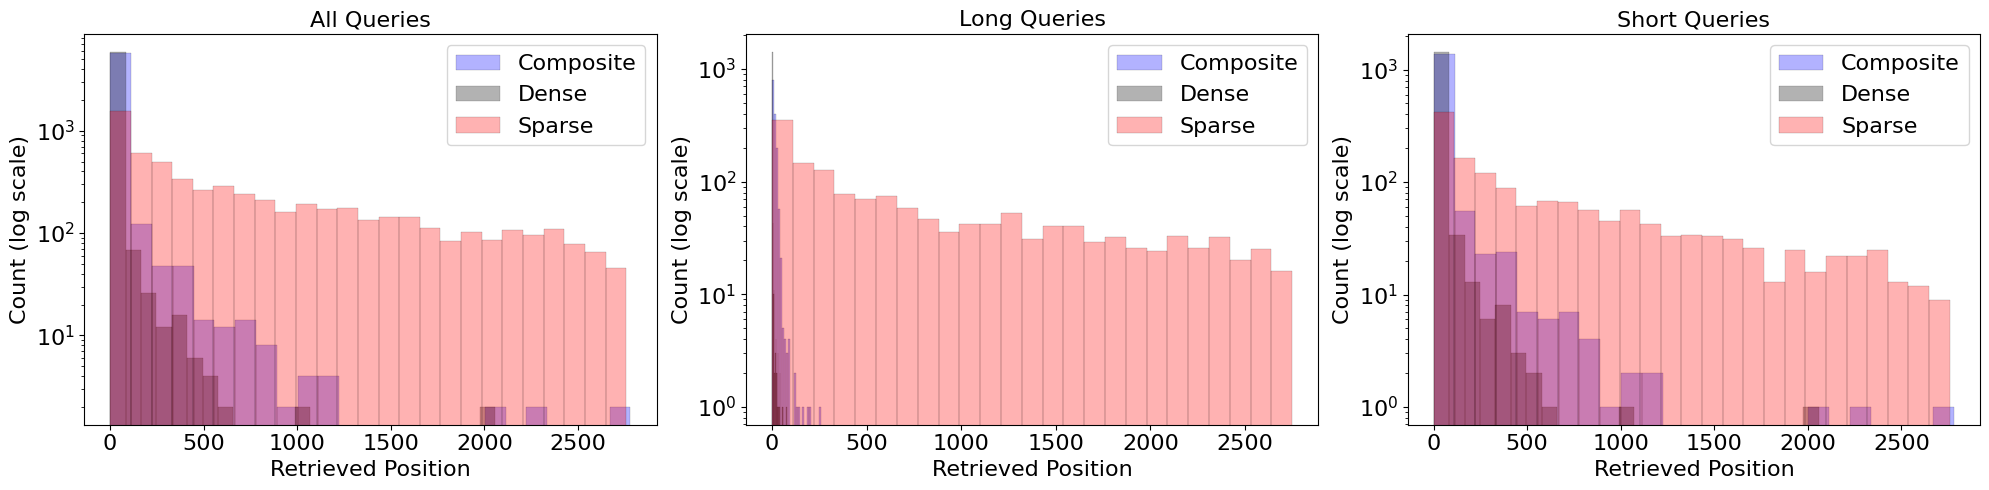

In [7]:
# Set up the figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Define colors for each retrieval method
colors = {'Dense': 'black', 'Composite': 'blue', 'Sparse': 'red'}

bins = 25
title_font = 16
body_font = title_font

# Plot histograms with KDE for each query type
for retrieval_method in ['Composite', 'Dense', 'Sparse']:
    # All queries
    sns.histplot(data=data[data['Retrieval Method'] == retrieval_method],
                x='Retrieved Position', kde=False,
                ax=ax1, alpha=0.3, label=retrieval_method, 
                color=colors[retrieval_method], bins=bins,
                linewidth=0.1)
    ax1.set_title('All Queries', fontsize=title_font)
    ax1.set_xlabel('Retrieved Position', fontsize=body_font)
    ax1.set_ylabel('Count (log scale)', color='black', fontsize=body_font)
    ax1.set_yscale('log')
    ax1.legend(fontsize=body_font)
    ax1.tick_params(axis='both', labelsize=body_font)
    
    # Long queries
    sns.histplot(data=data[(data['Retrieval Method'] == retrieval_method) & 
                          (data['Query Type'] == 'Long')],
                x='Retrieved Position', kde=False,
                ax=ax2, alpha=0.3, label=retrieval_method,
                color=colors[retrieval_method], bins=bins,
                linewidth=0.1)
    ax2.set_title('Long Queries', fontsize=title_font)
    ax2.set_xlabel('Retrieved Position', fontsize=body_font)
    ax2.set_ylabel('Count (log scale)', color='black', fontsize=body_font)
    ax2.set_yscale('log')
    ax2.legend(fontsize=body_font)
    ax2.tick_params(axis='both', labelsize=body_font)
    
    # Short queries
    sns.histplot(data=data[(data['Retrieval Method'] == retrieval_method) & 
                          (data['Query Type'] == 'Short')],
                x='Retrieved Position', kde=False,
                ax=ax3, alpha=0.3, label=retrieval_method,
                color=colors[retrieval_method], bins=bins,
                linewidth=0.1)
    ax3.set_title('Short Queries', fontsize=title_font)
    ax3.set_xlabel('Retrieved Position', fontsize=body_font)
    ax3.set_ylabel('Count (log scale)', color='black', fontsize=body_font)
    ax3.set_yscale('log')
    ax3.legend(fontsize=body_font)
    ax3.tick_params(axis='both', labelsize=body_font)

plt.tight_layout()
plt.show()


<Figure size 1500x1000 with 0 Axes>

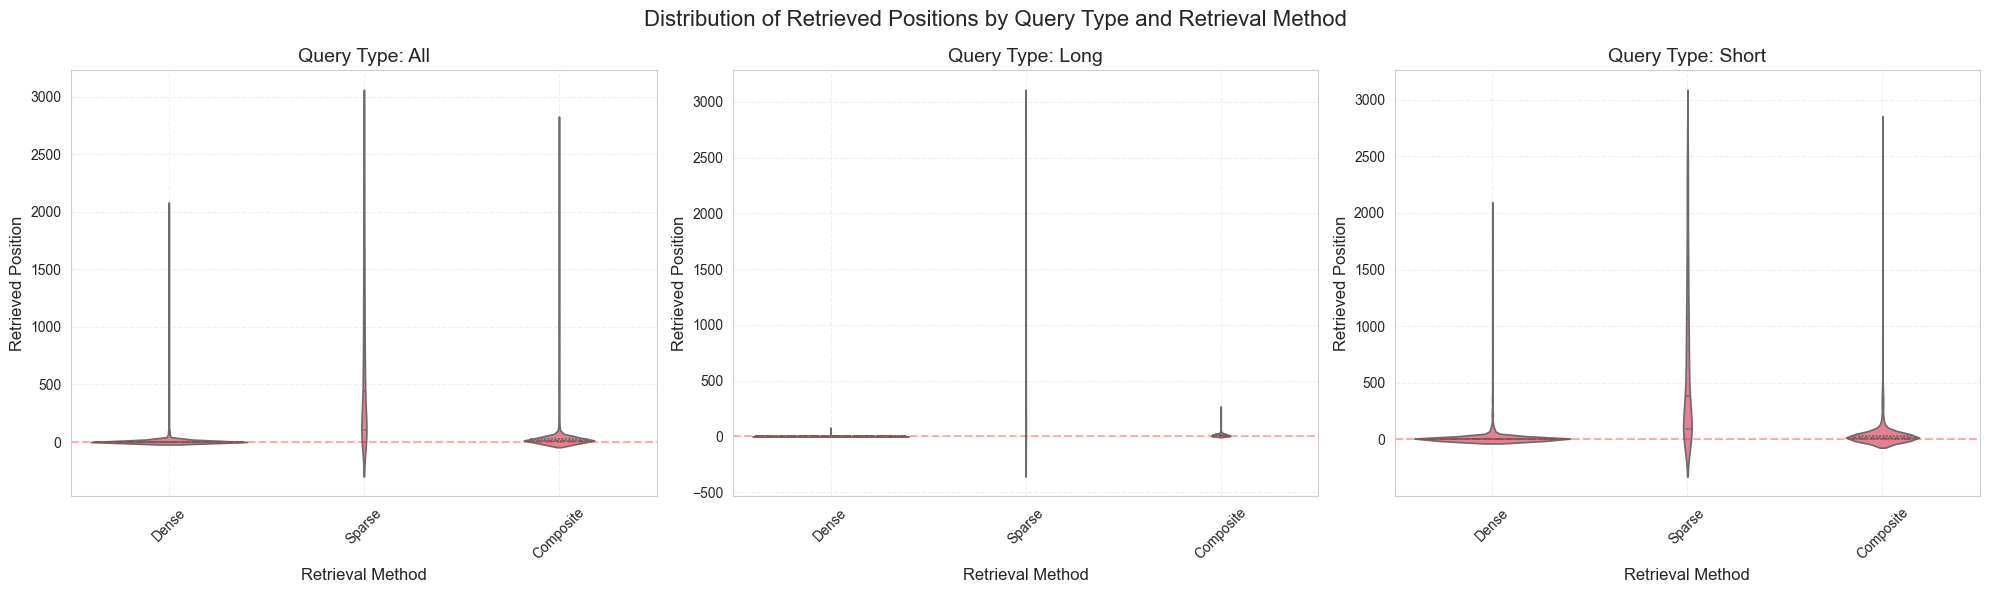

In [8]:
# Create violin plots
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")
sns.set_palette("husl")

# Create subplots for each query type
query_types = ['All', 'Long', 'Short']
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distribution of Retrieved Positions by Query Type and Retrieval Method', fontsize=16)

for i, query_type in enumerate(query_types):
    ax = axes[i]
    subset = data[data['Query Type'] == query_type]
    
    # Create violin plot
    sns.violinplot(
        data=subset,
        x='Retrieval Method',
        y='Retrieved Position',
        ax=ax,
        inner='quartile'  # Show quartiles inside the violin
    )
    
    # Customize the plot
    ax.set_title(f'Query Type: {query_type}', fontsize=14)
    ax.set_xlabel('Retrieval Method', fontsize=12)
    ax.set_ylabel('Retrieved Position', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)
    
    # Add a horizontal line at y=1 to highlight the best possible position
    ax.axhline(y=1, color='r', linestyle='--', alpha=0.3)
    
    # Set y-axis to log scale to better visualize the distribution
    # ax.set_yscale('log')
    
    # Add grid for better readability
    ax.grid(True, which='both', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
query = """
SELECT
    query_type AS [Query Type],
    IIF(retrieval_method = 'bm25', 'Sparse', IIF(retrieval_method = 'chroma', 'Dense', 'Composite')) AS [Retrieval Method],
    sample_size AS [Sample Size],
    prob_top_1 AS [Prob(pos=1)],
    prob_top_3 AS [Prob(pos<=3)],
    prob_top_5 AS [Prob(pos<=5)],
    prob_top_10 AS [Prob(pos<=10)]
FROM 
    v_evaluation_summary
"""
pdata =  pd.read_sql(query, conn)
pdata['Query Type'] = pdata['Query Type'].apply(lambda x: x.title())
pdata

,Query Type,Retrieval Method,Sample Size,Prob(pos=1),Prob(pos<=3),Prob(pos<=5),Prob(pos<=10)
0,All,Sparse,3001,0.0107,0.0230,0.0353,0.0630
1,Long,Sparse,1500,0.0080,0.0193,0.0307,0.0560
2,Short,Sparse,1501,0.0133,0.0266,0.0400,0.0700
3,All,Dense,3001,0.6128,0.7707,0.8304,0.8950
4,Long,Dense,1500,0.7887,0.9213,0.9540,0.9767
5,Short,Dense,1501,0.4370,0.6203,0.7069,0.8135
6,All,Composite,3001,0.1453,0.2276,0.2982,0.4135
7,Long,Composite,1500,0.1620,0.2533,0.3287,0.4560
8,Short,Composite,1501,0.1286,0.2019,0.2678,0.3711


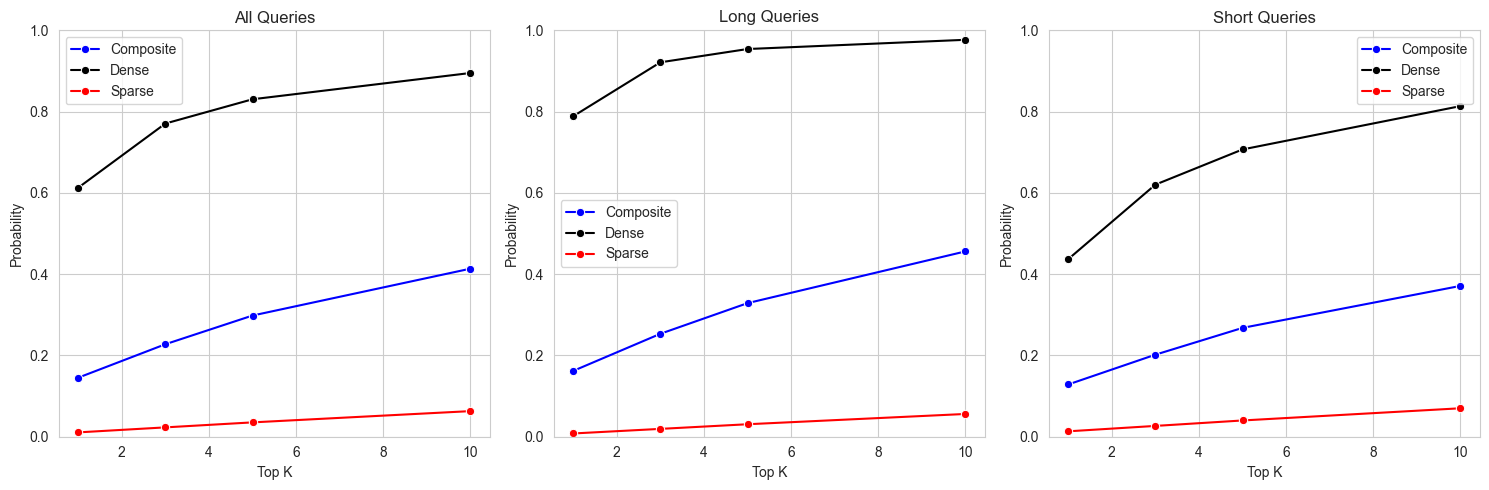

In [12]:
# Set up the plot style
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Define colors for each retrieval method
colors = {
    'Composite': 'blue',
    'Dense': 'black', 
    'Sparse': 'red'
}

# Create x values for plotting
x_values = [1, 3, 5, 10]

legend = ['Composite', 'Dense', 'Sparse']

# Plot for All queries
for method in legend:
    ldata = pdata[(pdata['Query Type'] == 'All') & (pdata['Retrieval Method'] == method)]
    plot_data = pd.DataFrame({
        'Top K': x_values,
        'Probability': [ldata['Prob(pos=1)'].iloc[0], ldata['Prob(pos<=3)'].iloc[0],
                       ldata['Prob(pos<=5)'].iloc[0], ldata['Prob(pos<=10)'].iloc[0]]
    })
    sns.lineplot(data=plot_data, x='Top K', y='Probability', ax=ax1, 
                color=colors[method], label=method, marker='o')

ax1.set_title('All Queries')
ax1.set_ylim(0, 1)
ax1.grid(True)

# Plot for Long queries
for method in legend:
    ldata = pdata[(pdata['Query Type'] == 'Long') & (pdata['Retrieval Method'] == method)]
    plot_data = pd.DataFrame({
        'Top K': x_values,
        'Probability': [ldata['Prob(pos=1)'].iloc[0], ldata['Prob(pos<=3)'].iloc[0],
                       ldata['Prob(pos<=5)'].iloc[0], ldata['Prob(pos<=10)'].iloc[0]]
    })
    sns.lineplot(data=plot_data, x='Top K', y='Probability', ax=ax2,
                color=colors[method], label=method, marker='o')

ax2.set_title('Long Queries')
ax2.set_ylim(0, 1)
ax2.grid(True)

# Plot for Short queries
for method in legend:
    ldata = pdata[(pdata['Query Type'] == 'Short') & (pdata['Retrieval Method'] == method)]
    plot_data = pd.DataFrame({
        'Top K': x_values,
        'Probability': [ldata['Prob(pos=1)'].iloc[0], ldata['Prob(pos<=3)'].iloc[0],
                       ldata['Prob(pos<=5)'].iloc[0], ldata['Prob(pos<=10)'].iloc[0]]
    })
    sns.lineplot(data=plot_data, x='Top K', y='Probability', ax=ax3,
                color=colors[method], label=method, marker='o')

ax3.set_title('Short Queries')
ax3.set_ylim(0, 1)
ax3.grid(True)

plt.tight_layout()
plt.show()

## Statistical Tests

### Kruskal-Wallis Test (Null = all medians are equal)

In [ ]:
# Initialize results container
results = []

# Loop over each query type (e.g., 'All', 'Long', 'Short')
for query_type in data['Query Type'].unique():
    subset = data[data['Query Type'] == query_type]

    # Group retrieved positions by retrieval method
    grouped = [
        group['Retrieved Position'].values
        for _, group in subset.groupby('Retrieval Method')
    ]

    methods = list(subset['Retrieval Method'].unique())

    # Perform Kruskal-Wallis test
    h_stat, p_val = kruskal(*grouped)

    # Interpretation
    if p_val < 0.05:
        interpretation = "Medians differ"
    else:
        interpretation = "Medians not sig. diff."

    # Store results
    results.append({
        "Query Type": query_type,
        "H Statistic": round(h_stat, 4),
        "p-value": round(p_val, 5),
        "Interpretation": interpretation
    })

# Convert to dataframe for display
results_df = pd.DataFrame(results)
results_df

### Dunn's test (to see which groups are different if Kruskall is stat sig)

In [ ]:
# Container for Kruskal-Wallis summary
kruskal_results = []

# For each Query Type, run Kruskal-Wallis + optionally Dunn's
for query_type in data['Query Type'].unique():
    subset = data[data['Query Type'] == query_type]

    # Group positions by method
    grouped = [
        group['Retrieved Position'].values
        for _, group in subset.groupby('Retrieval Method')
    ]

    methods = subset['Retrieval Method'].unique()

    # Kruskal-Wallis Test
    h_stat, p_val = kruskal(*grouped)

    if p_val < 0.05:
        interpretation = "Reject null: Medians differ"

        print(f"\nDunn's Test for Query Type = {query_type}")
        dunn_df = sp.posthoc_dunn(
            subset,
            val_col='Retrieved Position',
            group_col='Retrieval Method',
            p_adjust='bonferroni'
        )
        print(dunn_df.round(4))
    else:
        interpretation = "Fail to reject null: No significant difference"

    kruskal_results.append({
        "Query Type": query_type,
        "H Statistic": round(h_stat, 4),
        "p-value": round(p_val, 5),
        "Interpretation": interpretation
    })

# Summary table
kruskal_df = pd.DataFrame(kruskal_results)
print("\nKruskal-Wallis Summary Results:")
kruskal_df

### Chi-Squared

In [ ]:
# Results dictionary
results = {
    'Chi² Statistic': {},
    'p-value': {},
    'Interpretation': {}
}

# Loop over thresholds
for k in [1, 3, 5, 10]:
    # Mark whether each row is a success at this threshold
    data['Success'] = data['Retrieved Position'] <= k

    # Create contingency table
    contingency = pd.crosstab(data['Retrieval Method'], data['Success'])

    # Ensure both True/False columns exist
    for col in [True, False]:
        if col not in contingency.columns:
            contingency[col] = 0

    # Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency)

    # Fill results
    results['Chi² Statistic'][f'Top-{k}'] = round(chi2, 4)
    results['p-value'][f'Top-{k}'] = round(p, 5)
    results['Interpretation'][f'Top-{k}'] = (
        "Retrieval strategy success differs" if p < 0.05 else "Retrieval strategy success does not differ"
    )

# Create summary DataFrame
chi2_summary_df = pd.DataFrame(results)
print("\nChi-Square Summary Table:")
chi2_summary_df